# Метод Ньютона (20 баллов)

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import itertools
import math
import time


seed = 42
rng = np.random.default_rng(seed)

Вспомним основные свойства логистической регрессии с кросс-энтропийной функцией потерь:
1. Модель:

$$
g(x, a_i) = \frac{1}{1 + \exp \left[- \langle x, a_i \rangle\right]};
$$

2. Функция потерь:

$$
\ell(g(x, a_i), b_i) = -b_i \log \left[g(x, a_i)\right] - (1 - b_i) \log \left[1 -  g(x, a_i)\right].
$$

3. Полный вид оптимизационной задачи:

$$
\min_{x \in \mathbb{R}^d} \left[ f(x) = \frac{1}{n} \sum_{i=1}^n \ell \left(g(x, a_i), b_i \right) + \frac{\lambda}{2} \| x \|^2_2 \right],
$$

4. Градиент функции потерь:

$$
\nabla f(x) = \frac{1}{n} \sum_{i=1}^n (g(x, a_i) - b_i) a_i + \lambda x.
$$

5. Гессиан функции потерь:

$$
\nabla^2 f(x) = \frac{1}{n} \sum_{i=1}^n g(x, a_i)(1 - g(x, a_i)) a_i a_i^\top + \lambda I_d.
$$
   
6. Константа $L$-гладкости оценивается как

$$
L \geq \frac{1}{4n} \lambda_{\max} \left[A^\top A \right] + \lambda,
$$

7. Константа $\mu$-сильной выпуклости оценивается как $\mu \leq \lambda$.

В качестве дата-матрицы $A$ и целевого вектора $b$ рассмотрим данные из датасета [_mushrooms_](https://github.com/BRAIn-Lab-teaching/OPTIMIZATION-METHODS-COURSE/blob/ПМИ_осень_2025/Datasets/mushrooms.txt). Ниже представлена функция загрузки датасета.

In [2]:
url = "https://raw.githubusercontent.com/BRAIn-Lab-teaching/OPTIMIZATION-METHODS-COURSE/%D0%9F%D0%9C%D0%98_%D0%BE%D1%81%D0%B5%D0%BD%D1%8C_2025/Datasets/mushrooms.txt"
!wget -O mushrooms.txt "$url"

--2025-10-30 20:38:33--  https://raw.githubusercontent.com/BRAIn-Lab-teaching/OPTIMIZATION-METHODS-COURSE/%D0%9F%D0%9C%D0%98_%D0%BE%D1%81%D0%B5%D0%BD%D1%8C_2025/Datasets/mushrooms.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 879712 (859K) [text/plain]
Saving to: ‘mushrooms.txt’

mushrooms.txt       100%[===================>] 859.09K  --.-KB/s    in 0.005s  

2025-10-30 20:38:34 (185 MB/s) - ‘mushrooms.txt’ saved [879712/879712]



In [3]:
from sklearn.datasets import load_svmlight_file

#файл должен лежать в той же директории, что и notebook
dataset = "mushrooms.txt"

data = load_svmlight_file(dataset)
A, b = data[0].toarray(), data[1]

# Необходимое линейное преобразование
b = b - 1

С помощью функции ```train_test_split``` разделите датасет в отношении 4 к 1 (обучающая выборка должна быть в 4 раза больше, чем тестовая). Поставьте параметр ```random_state = 57```. В дальнейшем мы будем валидировать процесс обучения на тестовой выборке.

In [4]:
import sklearn
A_train, A_test, b_train, b_test = sklearn.model_selection.train_test_split(A, b, test_size=0.2, random_state = 57)

Для обучающей части $A_{train}$, $b_{train}$ оцените константы $L$ и $\mu$, положив равенство в полученной ранее оценке. Задайте $\lambda$ так, чтобы $\lambda \approx L / 1000$.

In [5]:
eigvals = np.linalg.eigvalsh(A_train.T.dot(A_train))
lambda_max = np.max(eigvals)
n_train = A_train.shape[0]
L = eigvals.max() / (4 * n_train)
mu = L / 1000
lambda_value = mu

assert math.isclose(L, 2.586914976545057,  rel_tol=1e-6),  "Константа L-гладкости найдена неверно"
assert math.isclose(mu, 0.002586914976545057, rel_tol=1e-6),  "Константа регуляризации найдена неверно"

Дополните функции подсчета сигмоиды, кросс-энтропии, градиента и гессиана оптимизируемой функции.

In [6]:
def sigmoid(x):
    """
    Вычисляет сигмоидную функцию.

    Параметры:
        x (np.array): Входное значение

    Возвращает:
        sigmoid (np.array) Значение сигмоидной функции для входных данных
    """
    """
    Было предупреждение о переполнении экспоненты, пришлось придумывать костыли, чтобы не было переполнения
    """

    pos_mask = (x >= 0)
    neg_mask = (x < 0)

    z = np.zeros_like(x)
    z[pos_mask] = np.exp(-x[pos_mask])
    z[neg_mask] = np.exp(x[neg_mask])

    result = np.zeros_like(x)
    result[pos_mask] = 1 / (1 + z[pos_mask])
    result[neg_mask] = z[neg_mask] / (1 + z[neg_mask])

    return result


def loss(x, A=A_train, b=b_train, lambda_value=L/1000):
    """
    Вычисляет значение эмпирического риска.

    Параметры:
        x (np.array): Вектор параметров модели
        A (np.array): Матрица признаков обучающей выборки
        b (np.array): Вектор меток обучающей выборки
        lambda_value (float): Параметр регуляризации

    Возвращает:
        loss (float): Значение функции потерь
    """

    epsilon = 1e-10

    g_value = sigmoid(A @ x)

    g_value = np.clip(g_value, epsilon, 1 - epsilon)

    cross_entropy_loss = -np.mean(b * np.log(g_value) + (1 - b) * np.log(1 - g_value))

    regularization = (lambda_value / 2) * np.sum(x**2)

    loss = cross_entropy_loss + regularization

    return loss


def grad(x, A=A_train, b=b_train, lambda_value=L/1000):
    """
    Вычисляет градиент функции потерь.

    Параметры:
        x (np.array): Вектор параметров модели
        A (np.array): Матрица признаков обучающей выборки
        b (np.array): Вектор меток обучающей выборки
        lambda_value (float): Параметр регуляризации

    Возвращает:
        grad (np.array): Градиент функции потерь
    """

    predictions = sigmoid(A @ x)

    grad = (A.T @ (predictions - b)) / len(b) + lambda_value * x

    return grad

def hess(x, A=A_train, b=b_train, lambda_value=L/1000):
    """
    Вычисляет гессиан функции потерь.

    Параметры:
        x (np.array): Вектор параметров модели
        A (np.array): Матрица признаков обучающей выборки
        b (np.array): Вектор меток обучающей выборки
        lambda_value (float): Параметр регуляризации

    Возвращает:
        hess (np.array): Гессиан функции потерь.
    """

    n = len(b)

    g_value = sigmoid(A @ x)
    S = np.diag(g_value * (1 - g_value))

    hess = (A.T @ S @ A) / n + lambda_value * np.eye(A.shape[1])

    return hess

В качестве критерия сходимости используем норму градиента.

In [7]:
def criterion(x, A=A_train, b=b_train, lambda_value=L/1000):
    """
    Вычисляет критерий остановки.

    Параметры:
        x (np.array): Текущая точка
        A (np.array): Матрица признаков
        b (np.array): Вектор меток
        lambda_value (float): Параметр регуляризации

    Возвращает:
        norm (float): Норма градиента
    """
    return np.linalg.norm(grad(x, A, b, lambda_value))

## Основная часть (10 баллов)

__Задача 1.__ Начнем с демпфированного метода Ньютона (с возможностью выбора шага).


**Псевдокод алгоритма**

---

_Инициализация:_

- Размер шага $\{ \gamma_k \}_{k=0} > 0$
- Начальная точка $x^0 \in \mathbb{R}^d$
- Максимальное число итераций $K$

---

$k$_-ая итерация:_

$$x^{k+1} = x^k - \gamma_k \left(\nabla^2 f\left(x^k\right)\right)^{-1} \nabla f\left(x^k\right)$$

---

_Условие остановки:_
- Достигнуто максимальное число итераций $K$ или $\frac{\| \nabla f(x^k) \|_2}{\| \nabla f(x^0) \|_2} < \varepsilon$

---

_Выход:_
- Полученное значение $x^K$

__а)(2 балла)__ Допишите метод `damped_newton`.

_Замечание: вычисление обратной матрицы и последующее перемножение не являются оптимальным (с точки зрения временных затрат) способом найти нужное направление для шага. Подумайте, как можно было бы реализовать поиск направления с помощью одной функции из библиотеки `numpy.linalg`._

In [8]:
def damped_newton(A, b, lambda_value, grad, hess, criterion, x_0, eps=1e-8, max_iter=1000, **params):
    """
    Реализация демпфированного метода Ньютона.

    Параметры:
        A (np.array): Матрица признаков.
        b (np.array): Вектор целевых значений
        lambda_value (float): Параметр регуляризации
        grad (Callable): Функция вычисления градиента
        hess (Callable): Функция вычисления гессиана
        criterion (Callable): Функция критерия остановки
        x_0 (np.array): Начальная точка
        eps (float): Точность сходимости (критерий остановки)
        max_iter (int): Максимальное количество итераций
        params : Именованные гиперпараметры метода
            params['gamma'] : шаг

    Возвращает:
        x_k (np.array) : Найденное решение
        times (list) : Список значений времени на каждой итерации
        errors (list) : Список значений критерия сходимости на каждой итерации
    """
    times = []
    errors = []

    x_k = np.copy(x_0)
    start = time.time()
    times.append(start - start)
    err_0 = criterion(x_0, A, b, lambda_value)
    errors.append(criterion(x_k, A, b, lambda_value) / err_0)

    gamma = params.get('gamma', 1.0)

    for k in tqdm(range(max_iter)):

        gradient = grad(x_k, A, b, lambda_value)
        hessian = hess(x_k, A, b, lambda_value)

        direction = np.linalg.solve(hessian, gradient)

        x_k = x_k - gamma * direction

        times.append(time.time() - start)
        errors.append(criterion(x_k, A, b, lambda_value) / err_0)

        if errors[-1] < eps:
            break

    return x_k, times, errors

Запустите демпфированный метод Ньютона c шагом $\gamma_k = 1.0$ для следующих начальных приближений:
1. $x_0 = (0, \ldots, 0)^\top$ (вектор из всех нулей);
2. $x_0 = (1, \ldots, 1)^\top$ (вектор из всех единиц);
3. $x_0 = (2, \ldots, 2)^\top$ (вектор из всех двоек).

In [9]:
d = A_train.shape[1]
initial_points = [
    np.zeros(d),
    np.ones(d),
    np.ones(d) * 2
]

results_damped_newton = []

for point in initial_points:
  x_target, time_arr, errors = damped_newton(
    A_train, b_train, lambda_value, grad, hess, criterion,
    point, eps=1e-8, max_iter=200, gamma=1.0
  )
  results_damped_newton.append((time_arr, errors))

100%|██████████| 200/200 [00:52<00:00,  3.81it/s]


Постройте график сходимости.

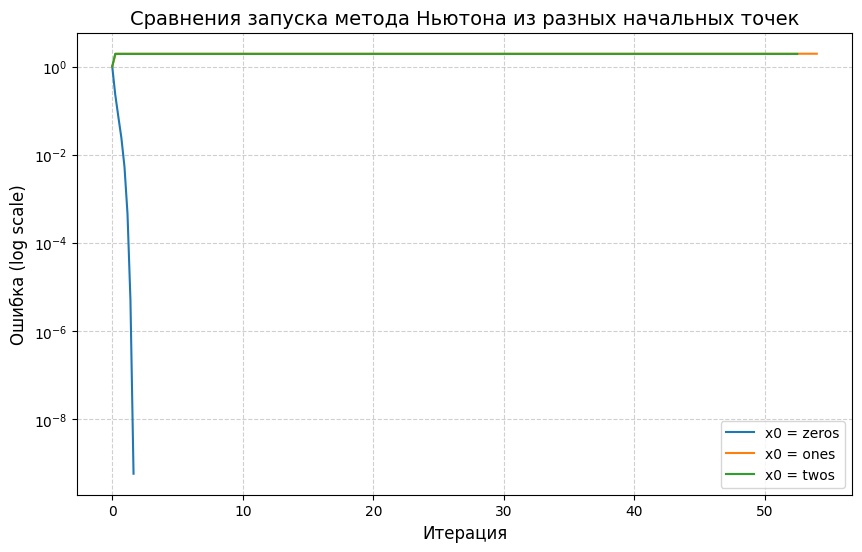

In [10]:
labels = ['zeros', 'ones', 'twos']
plt.figure(figsize=(10, 6))

for i, (time_arr, errors) in enumerate(results_damped_newton):
    plt.semilogy(time_arr, errors, label=f'x0 = {labels[i]}')

plt.xlabel('Итерация', fontsize=12)
plt.ylabel('Ошибка (log scale)', fontsize=12)
plt.title('Сравнения запуска метода Ньютона из разных начальных точек', fontsize=14)
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.legend()
plt.show()

Согласуются ли полученные результаты с теорией?

Да, сходимость классического метода Ньютона зависит от выбора начальной точки, т.к. он дает только локальную сходимость, а не глобальную.

__б)(2 балла)__ Чтобы улучшить сходимость, сделаем несколько начальных итераций с помощью метода градиентного спуска, а потом уже запустим метод Ньютона. Допишите код в методе `gd_dn`.

In [11]:
def gd_dn(A, b, lambda_value, grad, hess, criterion, x_0, eps=1e-8, max_iter=10, gd_max_iter=20, **params):
    """
    Реализация метода: сначала градиентный спуск, затем демпфированный метод Ньютона.

    Параметры:
        A (np.array): Матрица признаков.
        b (np.array): Вектор целевых значений
        lambda_value (float): Параметр регуляризации
        grad (Callable): Функция вычисления градиента
        hess (Callable): Функция вычисления гессиана
        criterion (Callable): Функция критерия остановки
        x_0 (np.array): Начальная точка
        eps (float): Точность сходимости (критерий остановки)
        max_iter (int): Максимальное количество итераций метода Ньютона
        gd_max_iter (int): Количество итераций градиентного спуска
        params : Именованные гиперпараметры метода
            params['gamma_gd']: шаг на итерации градиентного спуска
            params['gamma_newton']: шаг на итерации метода Ньютона

    Возвращает:
        x_k (np.array) : Найденное решение
        times (list) : Список значений времени на каждой итерации
        errors (list) : Список значений критерия сходимости на каждой итерации
    """
    times = []
    errors = []

    x_k = np.copy(x_0)
    start = time.time()
    times.append(start - start)
    err_0 = criterion(x_0, A, b, lambda_value)
    errors.append(criterion(x_k, A, b, lambda_value) / err_0)

    # Извлечение параметров
    gamma_gd = params.get('gamma_gd', 1e-3)
    gamma_newton = params.get('gamma_newton', 1.0)

    # === Этап 1: Градиентный спуск ===
    for k in tqdm(range(gd_max_iter), desc="GD phase"):

        gradient = grad(x_k, A, b, lambda_value)

        x_k = x_k - gamma_gd * gradient

        times.append(time.time() - start)
        errors.append(criterion(x_k, A, b, lambda_value) / err_0)

    # === Этап 2: Демпфированный метод Ньютона ===
    for k in tqdm(range(max_iter), desc="Newton phase"):

        gradient = grad(x_k, A, b, lambda_value)
        hessian = hess(x_k, A, b, lambda_value)

        direction = np.linalg.solve(hessian, gradient)

        x_k = x_k - gamma_newton * direction

        times.append(time.time() - start)
        errors.append(criterion(x_k, A, b, lambda_value) / err_0)

        if errors[-1] < eps:
            break

    return x_k, times, errors

Запустите улучшенный алгоритм с теми же стартовыми точками.

In [12]:
results_gd_dn = []

for point in initial_points:
  x_target, time_arr, errors = gd_dn(
    A_train, b_train, lambda_value, grad, hess, criterion,
    point, eps=1e-8, max_iter=200, gd_max_iter=50, gamma=1.0
  )
  results_gd_dn.append((time_arr, errors))

Newton phase: 100%|██████████| 200/200 [00:51<00:00,  3.90it/s]


Постройте график сходимости.

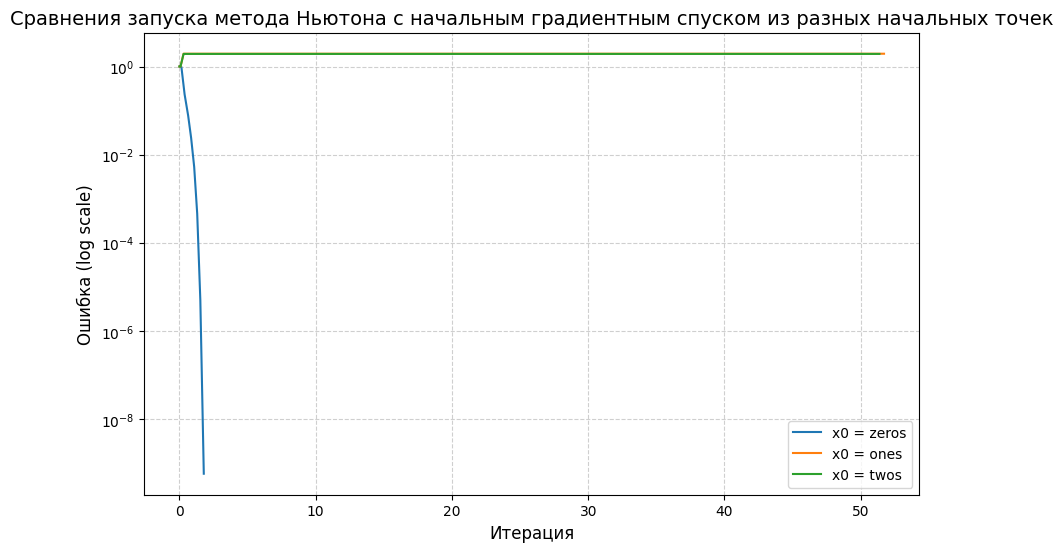

In [13]:
labels = ['zeros', 'ones', 'twos']
plt.figure(figsize=(10, 6))

for i, (time_arr, errors) in enumerate(results_gd_dn):
    plt.semilogy(time_arr, errors, label=f'x0 = {labels[i]}')

plt.xlabel('Итерация', fontsize=12)
plt.ylabel('Ошибка (log scale)', fontsize=12)
plt.title('Сравнения запуска метода Ньютона c начальным градиентным спуском из разных начальных точек', fontsize=14)
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.legend()
plt.show()

Напишите вывод.

__Задача 2.__ Вычисление обратной матрицы гессиана является крайне ресурсоемким, поэтому предлагается использовать вместо её точного значения некоторую аппроксимацию невырожденной положительно определенной матрицей. Такие методы называются *квазиньютоновскими*. В данной части будут рассмотрены два основных алгоритма.

__Псевдокод алгоритма__

---

_Инициализация:_

- Размер шага $\{ \gamma_k \}_{k=0} > 0$
- Начальная точка $x^0 \in \mathbb{R}^d$
- Начальное приближение обратной матрицы Гессиана $H_0 = I_d$
- Максимальное число итераций $K$

---

$k$_-ая итерация:_

1. Сделать шаг спуска:

   $$
   x^{k+1} = x^k - \gamma_k H_k \nabla f(x^k)
   $$

2. Обновить $H_k$

---

_Условие остановки:_
- Достигнуто максимальное число итераций $K$ или $\frac{\| \nabla f(x^k) \|_2}{\| \nabla f(x^0) \|_2} < \varepsilon$

---

_Выход:_
- Полученное значение $x^K$

__а) (2 балла)__ Реализуйте квазиньютоновский метод BFGS, с обновлением шага:

$$
H_{k+1} = \left( I - \frac{s_k y_k^T}{y_k^T s_k} \right) H_k \left( I - \frac{y_k s_k^T}{y_k^T s_k} \right) + \frac{s_k s_k^T}{y_k^T s_k}.
$$

Искать $\gamma_k$ будем с помощью метода Вульфа.

**Псевдокод алгоритма**

---

_Инициализация:_

- Начальная точка $x^k$
- Начальная точка $\gamma_0 > 0$
- Направление спуска $h^k$
- Максимальное число итераций $K$
- Множитель уменьшения шага $m \in (0, 1)$
- Параметры $\beta_1, \beta_2 \in (0, 1)$

---

1. Проверить условие Армихо:

$$
f\left(x^k + \gamma_k h^k\right) \leq f\left(x^k\right) + \beta_1 \gamma_k \langle \nabla f\left(x^k\right), h^k \rangle
$$

2. Проверить условие кривизны

$$
\langle \nabla f \left(x^k + \gamma_k h^k\right),  h^k \rangle \geq \beta_2 \langle \nabla f \left(x^k\right), h^k \rangle
$$

2. Если оба условия выполняются, вернуть $\gamma_k$. Если не выполняется Армихо — уменьшить шаг:

    $$\gamma_k = \gamma_k \cdot m$$

    и вернуться к 1. Иначе — увеличить шаг:

    $$\gamma_k = \gamma_k / m$$

    и вернуться к 1

---

_Условие остановки:_
- Достигнуто максимальное число итераций $K$

---

_Выход:_
- Полученное значение $\gamma_k$

In [14]:
def wolfe(A, b, lambda_value, loss, grad, x, h, beta1, beta2, gamma_mult, max_iters, gamma0):
    """
    Правило Вольфа.

    Параметры:
        A (np.array): Матрица признаков
        b (np.array): Вектор целевых значений
        lambda_value (float): Параметр регуляризации
        loss (Callable): Функция потерь
        grad (Callable): Функция вычисления градиента
        x (np.array): Текущая точка
        h (np.array): Направление спуска
        beta1 (float): Параметр условия достаточного убывания
        beta2 (float): Параметр кривизны
        gamma_mult (float): Множитель уменьшения шага
        max_iters (int): Максимальное число итераций подбора
        gamma0 (float): Начальное значение шага

    Возвращает:
        gamma (float): Найденное значение шага, удовлетворяющее условию Вольфа
    """
    gamma = gamma0
    counter = 0
    current_loss = loss(x, A, b, lambda_value)
    grad_x = grad(x, A, b, lambda_value)
    directional_derivative = grad_x.dot(h)

    while counter < max_iters:

        x_new = x + gamma * h
        new_loss = loss(x_new, A, b, lambda_value)
        grad_new = grad(x_new, A, b, lambda_value)
        new_directional_derivative = grad_new.dot(h)

        armijo_condition = new_loss <= current_loss + beta1 * gamma * directional_derivative

        curvature_condition = new_directional_derivative >= beta2 * directional_derivative

        if armijo_condition and curvature_condition:
            return gamma

        if not armijo_condition:
            gamma *= gamma_mult
        else:
            gamma /= gamma_mult

        counter += 1

    return gamma

Запустите метод `bfgs` для трех различных начальных точек.

In [15]:
def bfgs(A, b, lambda_value, loss, grad, criterion, x_0, eps=1e-16, max_iter=100, **params):
    """
    Реализация квази-ньютоновского метода BFGS.

    Параметры:
        A (np.array): Матрица признаков размерности
        b (np.array): Вектор целевых значений размерности
        lambda_value (float): Параметр регуляризации
        loss (Callable): Функция потерь
        grad (Callable): Функция вычисления градиента
        criterion (Callable): Функция критерия остановки
        x_0 (np.array): Начальная точка оптимизации
        eps (float): Точность сходимости
        max_iter (int): Максимальное количество итераций
        params (dict): Дополнительные параметры для line_search:
            params['beta1'] (float): Первый параметр
            params['beta2'] (float): Второй параметр (не используется в правиле Армихо)
            params['gamma_mult'] (float): Множитель для уменьшения шага
            params['line_search_max_iter'] (int): Максимальное число итераций подбора шага
            params['gamma0'] (float): Начальное значение шага

    Возвращает:
        x_k (np.array): Найденное решение
        times (list): Список значений времени на каждой итерации
        errors (list): История значений критерия сходимости
    """
    times = []
    errors = []

    x_k = np.copy(x_0)
    start = time.time()
    times.append(start - start)
    err_0 = criterion(x_0, A, b, lambda_value)
    errors.append(criterion(x_k, A, b, lambda_value) / err_0)

    n = x_k.shape[0]
    H_k = np.eye(n)  # Инициализируем обратный гессиан как единичную матрицу

    beta1 = params.get('beta_1', 1e-4)
    beta2 = params.get('beta_2', 0.9)
    gamma_mult = params.get('gamma_mult', 0.5)
    line_search_max_iter = params.get('line_search_max_iter', 20)
    gamma0 = params.get('gamma0', 1.0)

    g_prev = grad(x_k, A, b, lambda_value)
    y_k = s_k = 0

    for k in tqdm(range(max_iter)):

        direction = -H_k @ g_prev

        gamma_k = wolfe(A, b, lambda_value, loss, grad, x_k, direction,
                       beta1, beta2, gamma_mult, line_search_max_iter, gamma0)

        x_new = x_k + gamma_k * direction
        g_new = grad(x_new, A, b, lambda_value)

        s_k = x_new - x_k
        y_k = g_new - g_prev

        rho_k = 1.0 / (y_k @ s_k)
        I = np.eye(n)
        H_k = (I - rho_k * np.outer(s_k, y_k)) @ H_k @ (I - rho_k * np.outer(y_k, s_k)) + rho_k * np.outer(s_k, s_k)

        x_k = x_new
        g_prev = g_new

        times.append(time.time() - start)
        errors.append(criterion(x_k, A, b, lambda_value) / err_0)

        if errors[-1] < eps:
            break

    return x_k, times, errors

In [16]:
bfgs_params = {
    'beta_1': 1e-2,
    'beta_2': 0.9,
    'gamma_mult': 0.5,
    'line_search_max_iter': 20,
    'gamma0': 1.0
}

bfgs_results = []

for i, x0 in enumerate(initial_points):
    x_opt, times, errors = bfgs(A_train, b_train, L/1000, loss, grad, criterion, x0, max_iter=600, **bfgs_params)
    bfgs_results.append((times, errors))

 52%|█████▏    | 313/600 [00:02<00:02, 109.90it/s]


Постройте сравнительные графики с демпфированным методом Ньютона с градиентным спуском. Сравнения должны быть проведены как по итерациям, так и по времени.

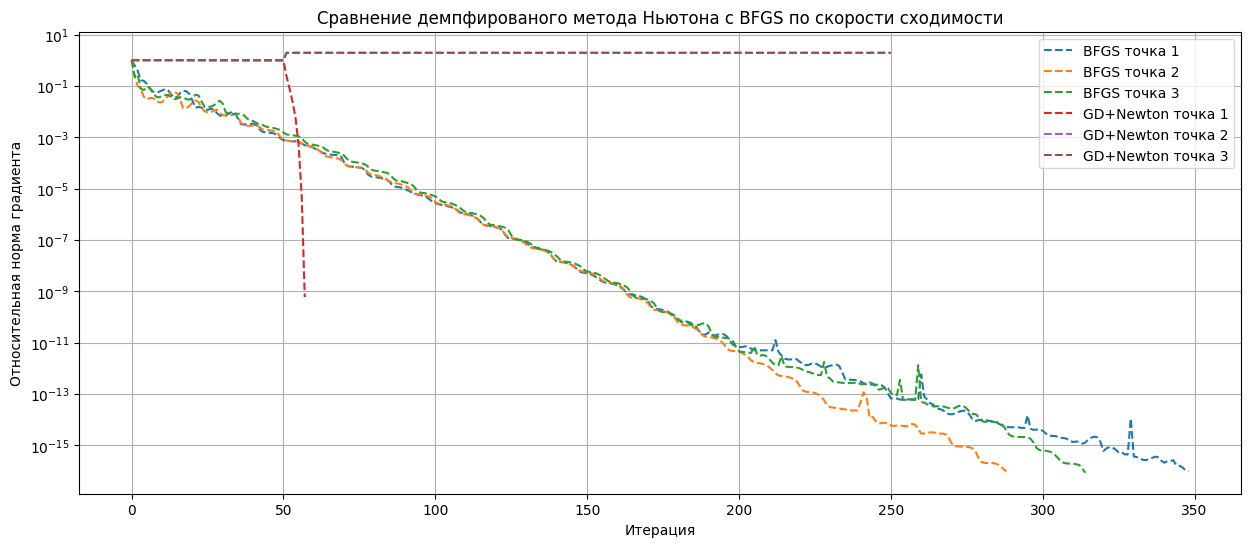

In [17]:
plt.figure(figsize=(15, 6))
for i, (times, errors) in enumerate(bfgs_results):
    plt.semilogy(errors, label=f'BFGS точка {i+1}', linestyle='--')

for i, (times, errors) in enumerate(results_gd_dn):
    plt.semilogy(errors, label=f'GD+Newton точка {i+1}', linestyle='--')

plt.xlabel('Итерация')
plt.ylabel('Относительная норма градиента')
plt.title('Сравнение демпфированого метода Ньютона с BFGS по скорости сходимости')
plt.legend()
plt.grid(True)

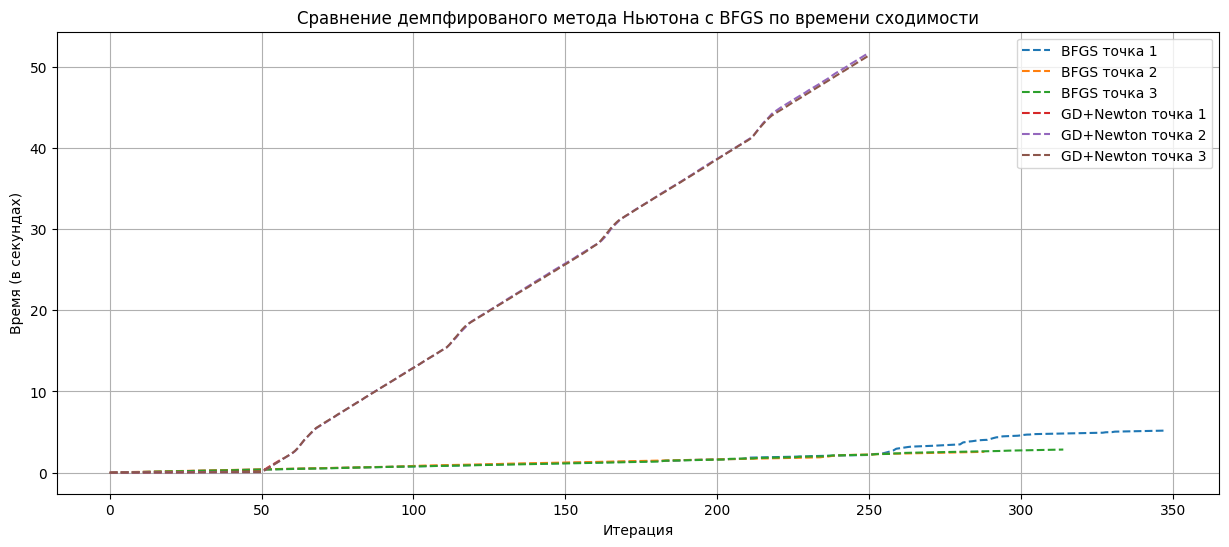

In [18]:
plt.figure(figsize=(15, 6))
for i, (times, errors) in enumerate(bfgs_results):
    plt.plot(times, label=f'BFGS точка {i+1}', linestyle='--')

for i, (times, errors) in enumerate(results_gd_dn):
    plt.plot(times, label=f'GD+Newton точка {i+1}', linestyle='--')

plt.xlabel('Итерация')
plt.ylabel('Время (в секундах)')
plt.title('Сравнение демпфированого метода Ньютона с BFGS по времени сходимости')
plt.legend()
plt.grid(True)

__б) (2 балла)__ Аппроксимация BFGS далеко не единственная. Поэтому также предлагается рассмотреть метод SR1 со следующим обновлением обратного гессиана:

$$
H_{k + 1} = H_k + \frac{(s_k - H_k y_k)(s_k - H_k y_k)^\top}{(s_k - H_k y_k)^\top y_k}.
$$

In [19]:
def sr1(A, b, lambda_value, loss, grad, criterion, x_0, eps=1e-16, max_iter=100, **params):
    """
    Реализация квази-ньютоновского метода SR1.

    Параметры:
        A (np.array): Матрица признаков размерности
        b (np.array): Вектор целевых значений размерности
        lambda_value (float): Параметр регуляризации
        loss (Callable): Функция потерь
        grad (Callable): Функция вычисления градиента
        criterion (Callable): Функция критерия остановки
        x_0 (np.array): Начальная точка оптимизации
        eps (float): Точность сходимости
        max_iter (int): Максимальное количество итераций
        params (dict): Дополнительные параметры для line_search:
            params['beta1'] (float): Первый параметр
            params['beta2'] (float): Второй параметр (не используется в правиле Армихо)
            params['gamma_mult'] (float): Множитель для уменьшения шага
            params['line_search_max_iter'] (int): Максимальное число итераций подбора шага
            params['gamma0'] (float): Начальное значение шага

    Возвращает:
        x_k (np.array): Найденное решение
        times (list): Список значений времени на каждой итерации
        errors (list): История значений критерия сходимости
    """
    times = []
    errors = []

    x_k = np.copy(x_0)
    start = time.time()
    times.append(start - start)
    err_0 = criterion(x_0, A, b, lambda_value)
    errors.append(criterion(x_k, A, b, lambda_value) / err_0)

    n = x_k.shape[0]
    H_k = np.eye(n)  # Инициализируем обратный гессиан как единичную матрицу

    beta1 = params.get('beta_1', 1e-4)
    beta2 = params.get('beta_2', 0.9)
    gamma_mult = params.get('gamma_mult', 0.5)
    line_search_max_iter = params.get('line_search_max_iter', 20)
    gamma0 = params.get('gamma0', 1.0)

    g_prev = grad(x_k, A, b, lambda_value)

    for k in tqdm(range(max_iter)):

        direction = -H_k @ g_prev

        gamma_k = wolfe(A, b, lambda_value, loss, grad, x_k, direction,
                       beta1, beta2, gamma_mult, line_search_max_iter, gamma0)

        x_new = x_k + gamma_k * direction
        g_new = grad(x_new, A, b, lambda_value)

        s_k = x_new - x_k
        y_k = g_new - g_prev
        diff = s_k - H_k @ y_k

        H_k = H_k + np.outer(diff, diff) / (diff @ y_k)

        x_k = x_new
        g_prev = g_new


        times.append(time.time() - start)
        errors.append(criterion(x_k, A, b, lambda_value) / err_0)

        if errors[-1] < eps:
            break

    return x_k, times, errors

Запустите метод `sr1` для трех различных начальных точек.

In [20]:
sr1_results = []
for i, x0 in enumerate(initial_points):
    x_opt, times, errors = sr1(A_train, b_train, lambda_value, loss, grad, criterion, x0, max_iter=500, **bfgs_params)
    sr1_results.append((x_opt, times, errors))

 42%|████▏     | 208/500 [00:02<00:04, 71.20it/s] /tmp/ipython-input-3006990129.py:61: RuntimeWarning: divide by zero encountered in divide
  H_k = H_k + np.outer(diff, diff) / (diff @ y_k)
/tmp/ipython-input-3006990129.py:61: RuntimeWarning: invalid value encountered in divide
  H_k = H_k + np.outer(diff, diff) / (diff @ y_k)
 38%|███▊      | 189/500 [00:02<00:04, 70.75it/s]


Постройте сравнительные графики `bfgs` и `sr1` по числу итераций и времени.

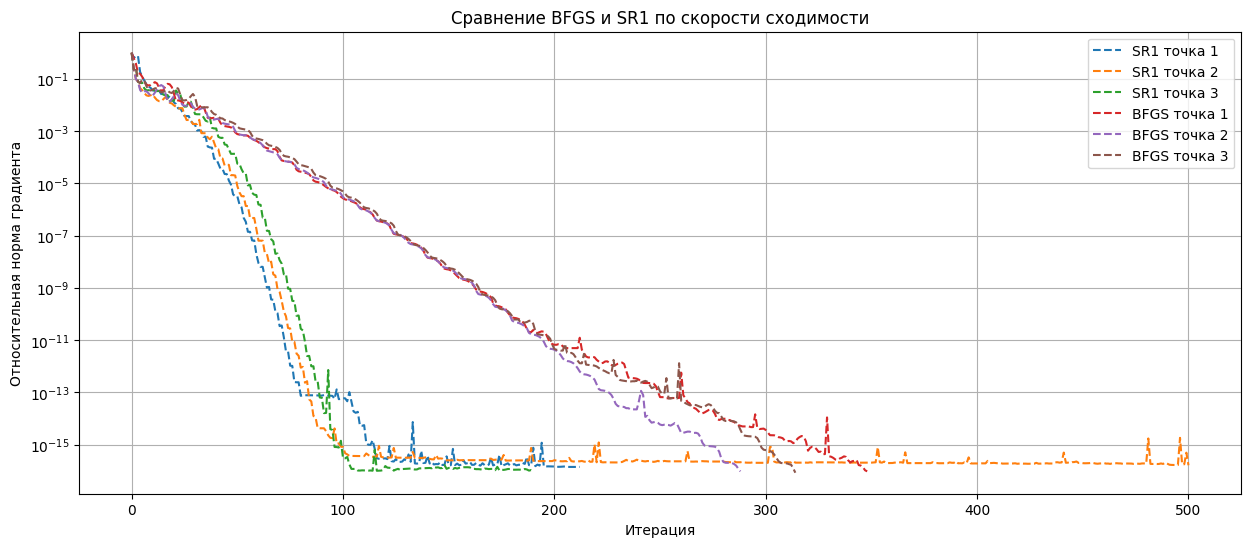

In [21]:
plt.figure(figsize=(15, 6))
for i, (x_opt, times, errors) in enumerate(sr1_results):
    plt.semilogy(errors, label=f'SR1 точка {i+1}', linestyle='--')

for i, (times, errors) in enumerate(bfgs_results):
    plt.semilogy(errors, label=f'BFGS точка {i+1}', linestyle='--')

plt.xlabel('Итерация')
plt.ylabel('Относительная норма градиента')
plt.title('Сравнение BFGS и SR1 по скорости сходимости')
plt.legend()
plt.grid(True)

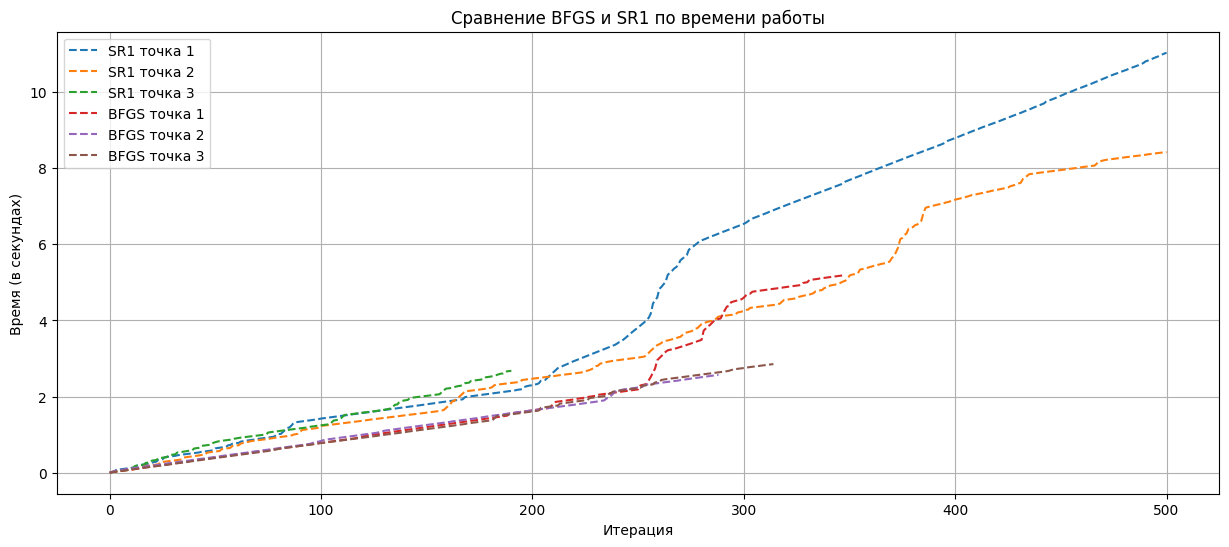

In [22]:
plt.figure(figsize=(15, 6))
for i, (x_opt, times, errors) in enumerate(sr1_results):
    plt.plot(times, label=f'SR1 точка {i+1}', linestyle='--')

for i, (times, errors) in enumerate(bfgs_results):
    plt.plot(times, label=f'BFGS точка {i+1}', linestyle='--')

plt.xlabel('Итерация')
plt.ylabel('Время (в секундах)')
plt.title('Сравнение BFGS и SR1 по времени работы')
plt.legend()
plt.grid(True)

__в) (2 балла)__ Сравните работу `bfgs` и `sr1` с ускоренным методом Нестерова.

In [23]:
def NAG(A, b, lambda_value, grad, criterion, x_0, eps=1e-8, max_iter=1000, **params):
    """
    Реализация метода ускоренного градиента Нестерова.

    Параметры:
        A (np.array): Матрица признаков
        b (np.array): Вектор целевых значений
        lambda_value (float): Параметр регуляризации
        grad (Callable): Функция вычисления градиента в точке
        criterion (Callable): Функция критерия остановки
        x_0 (np.array): Начальная точка оптимизации
        eps (float): Точность сходимости (критерий остановки)
        max_iter (int): Максимальное количество итераций
        params : Именованные гиперпараметры метода
            params['gamma'] : функция шага на k-ой итерации
            params['tau'] : функция момента на k-ой итерации

    Возвращает:
        x_k (np.array) : Найденное решение
        times (list) : Список значений времени на каждой итерации
        errors (list) : Список значений критерия сходимости на каждой итерации
    """
    times = []
    errors = []

    x_k = np.copy(x_0)
    x_k_old = np.copy(x_0)
    start = time.time()
    times.append(start - start)
    err_0 = criterion(x_0, A, b, lambda_value)
    errors.append(criterion(x_k, A, b, lambda_value) / err_0)

    gamma_func = params.get('gamma', lambda k: 0.01)
    tau_func = params.get('tau', lambda k: 0.9)

    for k in tqdm(range(max_iter)):

        gamma_k = gamma_func(k)
        tau_k = tau_func(k)

        y_k = x_k + tau_k * (x_k - x_k_old)

        gradient = grad(y_k, A, b, lambda_value)

        x_k_old = x_k.copy()

        x_k = y_k - gamma_k * gradient

        times.append(time.time() - start)
        errors.append(criterion(x_k, A, b, lambda_value) / err_0)

        if errors[-1] < eps:
            break

    return x_k, times, errors

In [24]:
gamma_func = lambda k: 1 / L
tau_func = lambda k: (np.sqrt(L) - np.sqrt(mu)) / (np.sqrt(L) + np.sqrt(mu))
nag_results = []
for i, x0 in enumerate(initial_points):
    x_opt, times, errors = NAG(A_train, b_train, lambda_value, grad, criterion, x0, max_iter=1000, gamma=gamma_func, tau=tau_func)
    nag_results.append((x_opt, times, errors))

 55%|█████▍    | 548/1000 [00:01<00:01, 398.19it/s]


Постройте графики сходимости от количества итераций и от времени.

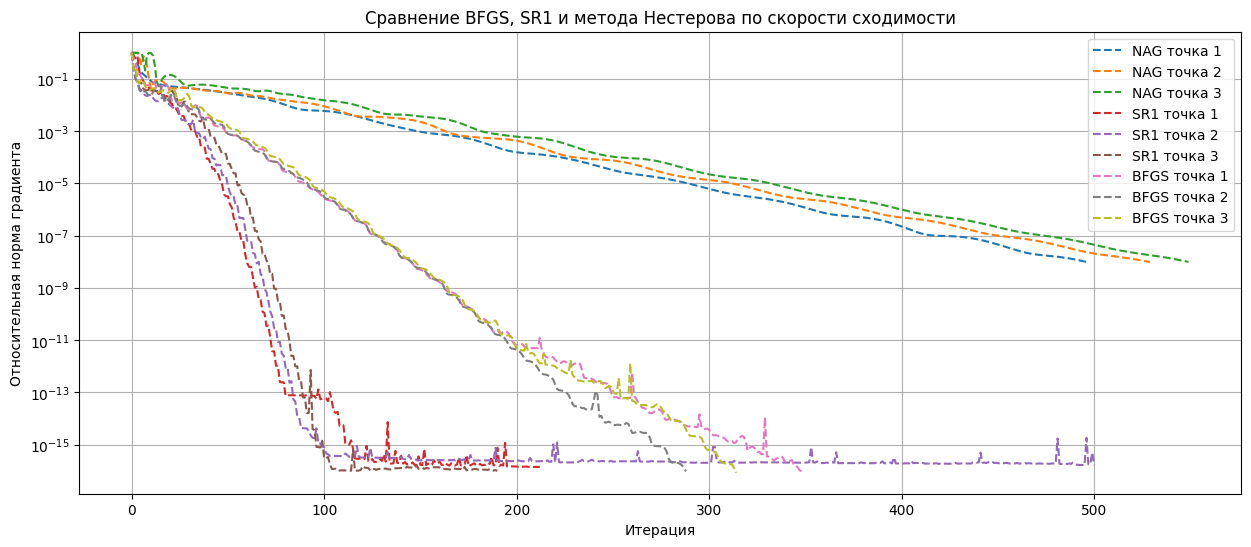

In [25]:
plt.figure(figsize=(15, 6))
for i, (x_opt, times, errors) in enumerate(nag_results):
    plt.semilogy(errors, label=f'NAG точка {i+1}', linestyle='--')

for i, (x_opt, times, errors) in enumerate(sr1_results):
    plt.semilogy(errors, label=f'SR1 точка {i+1}', linestyle='--')

for i, (times, errors) in enumerate(bfgs_results):
    plt.semilogy(errors, label=f'BFGS точка {i+1}', linestyle='--')

plt.xlabel('Итерация')
plt.ylabel('Относительная норма градиента')
plt.title('Сравнение BFGS, SR1 и метода Нестерова по скорости сходимости')
plt.legend()
plt.grid(True)

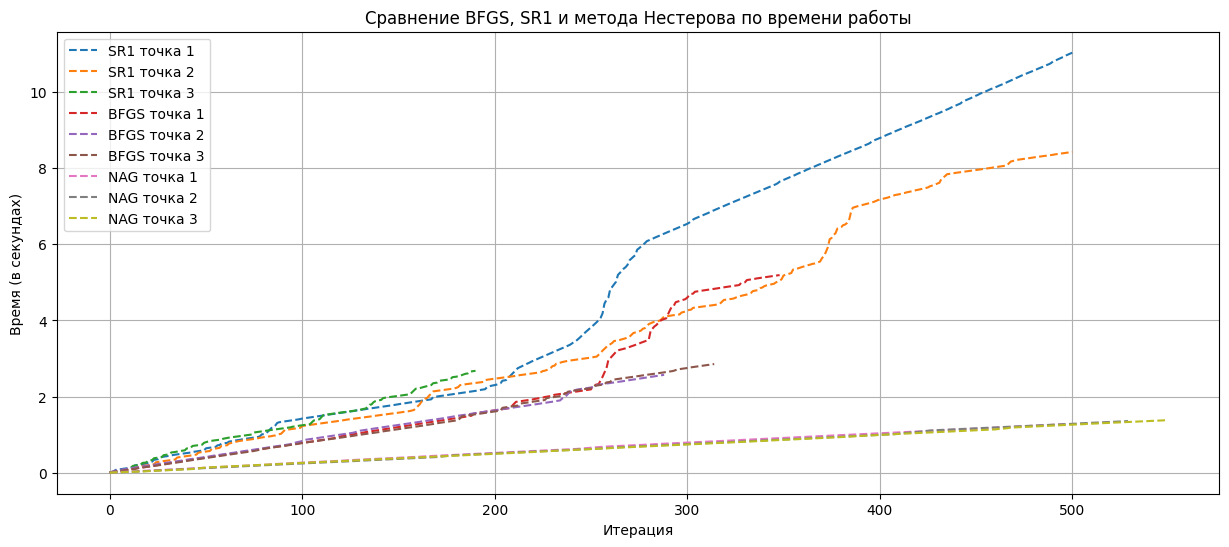

In [27]:
plt.figure(figsize=(15, 6))
for i, (x_opt, times, errors) in enumerate(sr1_results):
    plt.plot(times, label=f'SR1 точка {i+1}', linestyle='--')

for i, ( times, errors) in enumerate(bfgs_results):
    plt.plot(times, label=f'BFGS точка {i+1}', linestyle='--')

for i, (x_opt, times, errors) in enumerate(nag_results):
    plt.plot(times, label=f'NAG точка {i+1}', linestyle='--')

plt.xlabel('Итерация')
plt.ylabel('Время (в секундах)')
plt.title('Сравнение BFGS, SR1 и метода Нестерова по времени работы')
plt.legend()
plt.grid(True)

## Дополнительная часть (10 баллов)

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

__Задача 3.__ В этой задаче мы рассмотрим прикладные методы для задач глубокого обучения. Для начала введем понятие _pre-conditioning_. Предобуславливание (pre-conditioning) — это техника, которая помогает улучшить сходимость градиентных методов за счёт учёта кривизны целевой функции. Идея заключается в том, чтобы "вытянуть" или "сжать" пространство параметров так, чтобы градиент указывал более прямой путь к минимуму.

В классическом `SGD` обновление происходит по формуле

$$
x^{k + 1} = x^k - \gamma_k \nabla f_i\left(x^k\right).
$$

Однако если функция $f$ имеет сильно различающиеся масштабы по разным направлениям (например, из-за несбалансированности весов в сети), то градиент может указывать на "зигзагообразную" траекторию, что замедляет обучение (см. [статью](https://www.cs.toronto.edu/~jmartens/docs/Deep_HessianFree.pdf)).

- __Интуиция использования предобуславливателя__

Предобуславливатель можно представить как матрицу, которая "исправляет" форму ландшафта потерь. Она преобразует градиент так, чтобы он указывал в сторону наискорейшего спуска в "переформатированном" пространстве. Формально, шаг с предобуславливателем $P_k$ будет выглядеть так:

$$
x^{k + 1} = x^k - \gamma_k P_k \nabla f_i\left(x^k\right).
$$

- __Связь с методами второго порядка__

Как вы могли уже догадаться, в качестве предобуславливателя в методе Ньютона используется обратный гессиан:

$$
x^{k + 1} = x^k - \gamma_k \left( \nabla f \left( x^k \right) \right)^{-1} \nabla f_i(x^k).
$$

Но в большинстве DL библиотек нет простого способа достать гессиан. Почему? Потому что его обращение требует $d^3$ операций (здесь и далее $d$ — размер матрицы). Для прикладных задач $d$ может достигать значений больше миллиарда, что мгновенно делает задачу вычислительно невозможной. Более того, стохастический шум, который возникает при обучении, сильно влияет на матрицу $\left( \nabla^2 f \left( x^k \right) \right)^{-1}$, что дестабилизирует процесс обучения.

В Квази-Ньютоновских методах мы аппроксимируем обратный гессиан посредством использования разниц градиентов и параметров. Казалось бы, улучшение видно не вооруженным глазом. Однако, все не так гладко — даже ограниченная по памяти версия ([L-BFGS](https://pages.cs.wisc.edu/~yudongchen/cs726_sp23/Lecture_23_L-BFGS.pdf), [L-SR1](https://optimization-online.org/wp-content/uploads/2015/06/4968.pdf) с ограничением на число используемых разниц градиентов и параметров) в прикладных задачах терпит крах, так как использует $\mathcal{O}(d^2)$ ресурсов для хранения $H_k$ в памяти GPU.
       
- __Практическое применение__

А теперь давайте вспомним, что на самом деле у нас веса в модели это не просто вектора, а матрицы $W \in \mathbb{R}^{d_{\text{in}} \times d_{\text{out}}}$. То есть их гессиан имеет размерность $\nabla^2 f \left( x^k \right) \in \mathbb{R}^{d_{\text{in}}d_{\text{out}} \times d_{\text{in}}d_{\text{out}}}$, что при возведении даже во вторую степень делает задачу не подсчитываемой за разумное время. Нужно каким-то образом научится получать предобуславливатель не тратя на вычисления все время вселенной.

__Кронекеровская факторизация - спасение?__

Кронекеровским произведением в тензорном анализе называется операция $\otimes$. Пусть даны матрицы $A \in \mathbb{R}^{m \times n}, B \in \mathbb{R}^{p \times q}$. Тогда

$$
A \otimes B = \begin{pmatrix}
a_{11} B & a_{12} B &\cdots & a_{1n} B \\
a_{21} B & a_{22} B &\cdots & a_{2n} B \\
\vdots & \vdots & \vdots & \vdots \\
a_{m1} B & a_{m2} B &\cdots & a_{mn} B \\
\end{pmatrix} \in \mathbb{R}^{mp \times nq}.
$$

Кронекерово произведение позволяет работать с тензорами в векторизованной форме, сохраняя при этом структуру данных. Это особенно полезно для построения приближений больших матриц через факторизацию Кронекера, что мы сейчас и рассмотрим.

Допустим, у нас есть большая матрица $M \in \mathbb{R}^{d_1 d_2 \times d_1 d_2}$. Её можно представить как:

$$
M \approx A \otimes B,
$$

где $A \in \mathbb{R}^{d_1 \times d_1}$, $B \in \mathbb{R}^{d_2 \times d_2}$. Вместо того чтобы хранить $M$ целиком — $\mathcal{O}(d_1^2 d_2^2)$, мы храним только $A$ и $B$ — всего $ \mathcal{O}(d_1^2 + d_2^2)$ элементов.

__а) (4 балла)__ Начнем с Метода [K-FAC](https://proceedings.mlr.press/v48/grosse16.html), который апроксиммирует гессиан с помощью кронекеровской факторизации:

$$
\nabla^2 f \left( X^k \right) \approx A_k \otimes G_k,
$$

где
- $A_k$ составлена из внешнего произведения активаций $a_k$, пришедших с предыдущего слоя:

$$
A_k = \mathbb{E} [a_k a_k^\top]
$$
  
- $G_k$ составлена из внешнего произведения градиентов $g_k$ по параметрам слоя:

$$
G_k = \mathbb{E} [g_k g_k^\top]
$$

То есть обновление весов слоя $X$ можно записать в следующем виде:

$$
X^{k + 1} = X^k - \gamma_k (A_k \otimes G_k)^{-1} \nabla f(X^k) = X^k - \gamma_k G_k^{-1} \nabla f(X^k) A_k^{-1}.
$$

Подробнее про последнее равенство можно прочитать в статье, приложенной выше. Такое обновление занимает намного меньше памяти, то есть применимо при масштабируемости. Более того, при эффективной реализации матричного произведения, оно отличается от обычного градиентного спуска в почти неотличимое от константы число раз.

Для стабильности будем использовать следующую формулу:

$$
X^{k + 1} = X^k - \gamma_k (A_k \otimes G_k)^{-1} \nabla f(X^k) = X^k - \gamma_k G_k^{-\frac{1}{2}} \nabla f(X^k) A_k^{-\frac{1}{2}}.
$$

**Псевдокод алгоритма**

_Инициализация:_

- Размер шага $\{ \gamma_k \}_{k=0} > 0$.
- Начальная точка $x^0 \in \mathbb{R}^{d_{\text{in}} \times d_{\text{out}}}$.
- Коэффициент сглаживания $\beta \in [0, 1)$.
- Коэффициент регуляризации (для стабильности обращения) $\varepsilon > 0$.
- Максимальное число итераций $K$.

---

$k$_-ая итерация:_

1. Посчитать:

$$
A_k = \mathbb{E} [a_k a_k^\top]
$$

$$
G_k = \mathbb{E} [g_k g_k^\top]
$$

2. Обновить с экспоненциальным сглаживанием:

$$
A_{k} = \beta A_{k - 1} + (1 - \beta) A_k
$$
   
$$
G_{k} = \beta G_{k - 1} + (1 - \beta) G_k
$$

3. Добавить регуляризацию для устойчивости при поиске степени:

$$
A_{k} = A_{k} + \varepsilon I_{d_{in}}
$$

$$
G_{k} = G_{k} + \varepsilon I_{d_{out}}
$$

4. Обновить параметры:

$$
x^{k+1} = x^k - \gamma_k G_{k}^{-\frac{1}{2}} \nabla f(x^k) A_{k}^{-\frac{1}{2}}
$$

Дополните оптимизатор `KFACOptimizer`, который бы работал с линейным слоем. Заметьте также, что нужно передавать не группу оптимизируемых параметров, а всю модель (в противном случае невозможно будет получить ковариационные матрицы $A$ и $G$). Если слой не является `nn.Linear`-слоем, применяем обычный `SGD` с моментом вместо `KFAC`.

In [ ]:
class KFACOptimizer(torch.optim.Optimizer):
    """
    Реализация оптимайзера KFAC.

    Параметры:
        model (nn.Module): модель
        lr (float): Скорость обучения
        momentum (float): Коэффициент моментума
        damping (float): Коэффициент устойчивости
        weight_decay (float): Коэффициент L2-регуляризации
        factor_decay (float): Коэффициент сглаживания
    """
    def __init__(self, model, lr=1e-3, momentum=0.9, damping=1e-2, weight_decay=0, factor_decay=0.95):
        defaults = dict(lr=lr, momentum=momentum, damping=damping, weight_decay=weight_decay,
                        factor_decay=factor_decay)
        super().__init__(model.parameters(), defaults)

        self.model = model
        self.module_name_map = {}
        self.m_a = {}  # A: activations covariance
        self.m_g = {}  # G: gradient of output covariance

        module_id = 0
        for module in model.modules():
            if isinstance(module, nn.Linear):
                self.module_name_map[module] = module_id
                module_id += 1
                # Регистрируем хуки
                module.register_forward_hook(self._save_input)
                module.register_full_backward_hook(self._save_grad_output)

    def _save_input(self, module, input_, output):
        """
        Сохраняем входные данные для Linear
        """
        a = input_[0].detach().view(-1, module.in_features)
        mid = self.module_name_map[module]
        self.m_a[mid] = a.t() @ a / a.shape[0]

    def _save_grad_output(self, module, grad_input, grad_output):
        """
        Сохраняем градиенты по выходам
        """
        g = grad_output[0].detach().view(-1, module.out_features)
        mid = self.module_name_map[module]
        self.m_g[mid] = g.t() @ g / g.shape[0]

    def matrix_inverse_sqrt(self, mat, damping=1e-4):
        """
        Вычисляет M^{-1/2} через SVD.
        """
        U, S, V = torch.svd(mat)
        S_inv_sqrt = torch.diag(1.0 / (torch.sqrt(S) + damping))
        return U @ S_inv_sqrt @ V.t()

    def step(self, closure=None):
        """
        Выполняет один шаг оптимизатора.

        Параметры:
            closure (Сallable): Замыкание, которое пересчитывает модель и возвращает loss

        Возвращает:
            loss (float): Значение функции потерь
        """

        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            lr = group['lr']
            momentum = group['momentum']
            damping = group['damping']
            weight_decay = group['weight_decay']
            decay = group['factor_decay']

            for p in group['params']:
                if p.grad is None:
                    continue

                module = None
                for m in self.model.modules():
                    if any(p is param for param in m.parameters()):
                        if isinstance(m, nn.Linear) and m in self.module_name_map:
                            module = m
                        break

                # YOUR CODE HERE

        return loss

Обучите CGAN для генерации изображений цифр MNIST, используя оптимизатор `KFAC`.

In [ ]:
def trainer(
    num_epochs: int,
    batch_size: int,
    latent_dim: int,
    generator_class,
    discriminator_class,
    generator_optimizer_class,
    discriminator_optimizer_class,
    generator_optimizer_params: dict,
    discriminator_optimizer_params: dict,
    dataset,
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu',
    visualize: bool = True,
    n_disc_steps: int = 1,
    n_gen_steps: int = 1
):
    # DataLoader
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Инициализация моделей
    generator = generator_class(latent_dim=latent_dim).to(device)
    discriminator = discriminator_class().to(device)

    # Оптимизаторы
    def create_optimizer(optimizer_class, model, params):
        if optimizer_class.__name__ in ['KFACOptimizer', 'ShampooOptimizer']:
            return optimizer_class(model, **params)
        else:
            return optimizer_class(model.parameters(), **params)

    opt_gen = create_optimizer(generator_optimizer_class, generator, generator_optimizer_params)
    opt_disc = create_optimizer(discriminator_optimizer_class, discriminator, discriminator_optimizer_params)

    # Функция потерь
    criterion = nn.BCELoss()

    # История потерь
    losses = {
        'discriminator': [],
        'generator': []
    }

    # Фиксированные шум и метки для визуализации (по 6 примеров на каждую цифру)
    fixed_noise = torch.randn(60, latent_dim, device=device)  # 60 = 10 цифр × 6 примеров
    fixed_labels = torch.tensor([i for i in range(10) for _ in range(6)], device=device)  # [0,0,0,0,0,0, 1,1,1,1,1,1, ..., 9,9,9,9,9,9]

    # Подготовка графиков
    if visualize:
        fig, axes = plt.subplots(2, 1, figsize=(10, 8))
        loss_ax, image_ax = axes
        loss_ax.set_title("Loss Progress")
        image_ax.set_title("Generated Images")
        plt.tight_layout()
        display_id = display("", display_id=True)
    else:
        fig, loss_ax = plt.subplots(figsize=(8, 4))
        display_id = None

    def visualize_images(epoch):
        if not visualize:
            return

        with torch.no_grad():
            fake_images = generator(fixed_noise, fixed_labels).cpu().numpy()

        fake_images = (fake_images + 1) / 2

        image_ax.clear()
        image_ax.set_title("Сгенерированные картинки")

        # Сетка 10x6 (10 цифр, по 6 примеров)
        for i in range(60):
            row = i // 6  # Цифра (0-9)
            col = i % 6   # Пример (0-5)
            ax = image_ax.inset_axes([col/6, (9-row)/10, 1/6, 1/10])
            ax.imshow(fake_images[i].reshape(28, 28), cmap='gray')
            ax.axis('off')

        display_id.update(fig)

    def train_epoch(epoch):
        gen_losses = []
        disc_losses = []

        for real_images, real_labels in train_loader:
            real_images = real_images.to(device)
            real_labels = real_labels.to(device)
            batch_size = real_images.size(0)

            # Обновление дискриминатора
            for _ in range(n_disc_steps):
                opt_disc.zero_grad()

                # Реальные данные
                real_output = discriminator(real_images, real_labels)
                loss_real = criterion(real_output, torch.ones(batch_size, 1, device=device))

                # Фейковые данные
                z = torch.randn(batch_size, latent_dim, device=device)
                fake_labels = torch.randint(0, 10, (batch_size,), device=device)
                fake_images = generator(z, fake_labels)
                fake_output = discriminator(fake_images.detach(), fake_labels)
                loss_fake = criterion(fake_output, torch.zeros(batch_size, 1, device=device))

                loss_disc = loss_real + loss_fake
                loss_disc.backward()
                opt_disc.step()
                disc_losses.append(loss_disc.item())

            # Обновление генератора
            for _ in range(n_gen_steps):
                opt_gen.zero_grad()

                z = torch.randn(batch_size, latent_dim, device=device)
                fake_labels = torch.randint(0, 10, (batch_size,), device=device)
                fake_images = generator(z, fake_labels)
                fake_output = discriminator(fake_images, fake_labels)
                loss_gen = criterion(fake_output, torch.ones(batch_size, 1, device=device))

                loss_gen.backward()
                opt_gen.step()
                gen_losses.append(loss_gen.item())

        # Средние потери
        avg_gen_loss = np.mean(gen_losses)
        avg_disc_loss = np.mean(disc_losses)

        # Обновляем график потерь
        if visualize:
            loss_ax.clear()
            loss_ax.set_title("Loss")
            loss_ax.plot(losses['discriminator'], label='Discriminator', color='red')
            loss_ax.plot(losses['generator'], label='Generator', color='blue')
            loss_ax.legend()
            loss_ax.grid(True)
            loss_ax.set_xlabel('Эпоха')
            loss_ax.set_ylabel('Loss')

        print(f"Эпоха {epoch + 1} / {num_epochs} Loss D: {avg_disc_loss:.4f}, Loss G: {avg_gen_loss:.4f}")

        # Визуализация
        visualize_images(epoch)

        return avg_gen_loss, avg_disc_loss

    # Основной цикл обучения
    for epoch in range(num_epochs):
        avg_gen_loss, avg_disc_loss = train_epoch(epoch)
        losses['generator'].append(avg_gen_loss)
        losses['discriminator'].append(avg_disc_loss)

    plt.close()
    return generator, discriminator, losses

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100, num_classes=10, img_size=28):
        super().__init__()
        self.img_size = img_size
        self.label_emb = nn.Embedding(num_classes, latent_dim)

        self.model = nn.Sequential(
            nn.Linear(latent_dim * 2, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, img_size * img_size),
            nn.Tanh()
        )

    def forward(self, z, labels):
        label_embedding = self.label_emb(labels)
        gen_input = torch.cat((z, label_embedding), dim=1)
        img = self.model(gen_input)
        return img.view(-1, self.img_size, self.img_size)

class Discriminator(nn.Module):
    def __init__(self, num_classes=10, img_size=28):
        super().__init__()
        self.img_size = img_size
        self.label_emb = nn.Embedding(num_classes, img_size * img_size)

        self.model = nn.Sequential(
            nn.Linear(img_size * img_size * 2, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        x = x.view(-1, self.img_size * self.img_size)
        label_embedding = self.label_emb(labels)
        disc_input = torch.cat((x, label_embedding), dim=1)
        return self.model(disc_input)

In [ ]:
# Загрузка данных
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
dataset = datasets.MNIST(root='.', train=True, transform=transform, download=True)

Рекомендуется использовать следующие параметры для оптимизатора KFAC:

`lr`: `3e-4`, `momentum`: `0.9`, `damping`: `1e-2`, `factor_decay`: `0.95`.

In [ ]:
generator, discriminator, losses = trainer(
    num_epochs=50,
    batch_size=128,
    latent_dim=100,
    generator_class=Generator,
    discriminator_class=Discriminator,
    generator_optimizer_class=KFACOptimizer,
    discriminator_optimizer_class=KFACOptimizer,
    generator_optimizer_params={'lr': 3e-4, 'momentum': 0.9, 'damping': 1e-2, 'factor_decay': 0.95},
    discriminator_optimizer_params={'lr': 3e-4, 'momentum': 0.9, 'damping': 1e-2, 'factor_decay': 0.95},
    dataset=dataset,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    visualize=True,
    n_disc_steps=1,
    n_gen_steps=1
)

__б) (4 балла)__ Прокидывать хуки для запоминания матриц ковариаций на входе и выходе — дело неблагодарное, более того — плохо масштабируемое. Поэтому, в 2018 году в [статье](https://arxiv.org/pdf/1802.09568) предложили использовать только градиенты. В итоге, предобуславливатель стал иметь следующий вид:

$$
P_k = L_k^{-\frac{1}{4}} \otimes R_k^{-\frac{1}{4}},
$$

где $L_k = \sum_{i = 1}^k \alpha_i G_i G_i^\top$, $R_k = \sum_{i = 1}^k \alpha_i G_i^\top G_i$, а $G_i$ — градиенты на $i$-ом шаге. Коэффициенты используются для взвешенного усреднения по предыдущим шагам.

Внимательные читатели уже увидели явную несостыковку — почему используется степень ${-\frac{1}{4}}$, а не $\frac{1}{2}$? Потому что, используя только градиенты, мы дважды учитываем характер кривизны, который дает нам градиент, поэтому необходимо брать корень еще один раз.

**Псевдокод алгоритма**

_Инициализация:_

- Размер шага $\{ \gamma_k \}_{k=0} > 0$.
- Начальная точка $x^0 \in \mathbb{R}^{d_{\text{in}} \times d_{\text{out}}}$.
- Коэффициент сглаживания $\beta \in [0, 1)$.
- Коэффициент регуляризации (для стабильности обращения) $\varepsilon > 0$.
- Максимальное число итераций $K$.

---

$k$ _-ая итерация:_

1. Подсчитать левую и правую матрицы ковариации:

$$
L_k = \frac{1}{d_{in}} \nabla f\left(x^k\right) \left(\nabla f\left(x^k\right)\right)^\top
$$
   
$$
R_k = \frac{1}{d_{out}} \left(\nabla f\left(x^k\right)\right)^\top \nabla f\left(x^k\right)
$$

2. Обновить с экспоненциальным сглаживанием:

$$
L_{k} = \beta L_{k - 1} + (1 - \beta) L_k
$$

$$
R_{k} = \beta R_{k - 1} + (1 - \beta) R_k
$$

3. Добавить регуляризацию для устойчивости при поиске степени:

$$
L_{k} = L_{k} + \varepsilon I_{d_{in}}
$$

$$
R_{k} = R_{k} + \varepsilon I_{d_{out}}
$$

4. Обновить параметры:

$$
x^{k+1} = x^k - \gamma_k L_{k}^{-\frac{1}{4}} \nabla f\left(x^k\right) R_{k}^{-\frac{1}{4}}
$$

Дополните код оптимизатора `ShampooOptimizer`.

In [ ]:
class ShampooOptimizer(torch.optim.Optimizer):
    """
    Реализация оптимайзера Shampoo.

    Параметры:
        model (nn.Module): модель
        lr (float): Скорость обучения
        momentum (float): Коэффициент моментума
        damping (float): Коэффициент устойчивости
        weight_decay (float): Коэффициент L2-регуляризации
        factor_decay (float): Коэффициент сглаживания
    """
    def __init__(self, model, lr=1e-3, momentum=0.9, damping=1e-2, weight_decay=0, factor_decay=0.95):
        defaults = dict(lr=lr, momentum=momentum, damping=damping,
                        weight_decay=weight_decay, factor_decay=factor_decay)
        super().__init__(model.parameters(), defaults)

        self.model = model
        self.module_name_map = {}
        self.L = {}
        self.R = {}

        module_id = 0
        for module in model.modules():
            if isinstance(module, nn.Linear):
                self.module_name_map[module] = module_id
                module_id += 1

    def _compute_covariance(self, grad):
        """
        Вычисляет grad @ grad^T и grad^T @ grad
        """
        d_out, d_in = grad.shape
        L = grad @ grad.t() / d_in
        R = grad.t() @ grad / d_out
        return L, R

    def step(self, closure=None):
        """
        Выполняет один шаг оптимизатора.

        Параметры:
            closure (Сallable): Замыкание, которое пересчитывает модель и возвращает loss

        Возвращает:
            loss (float): Значение функции потерь
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            lr = group['lr']
            momentum = group['momentum']
            damping = group['damping']
            weight_decay = group['weight_decay']
            decay = group['factor_decay']

            for p in group['params']:
                if p.grad is None:
                    continue

                module = None
                for m in self.model.modules():
                    if any(p is param for param in m.parameters()):
                        if isinstance(m, nn.Linear) and m in self.module_name_map:
                            module = m
                        break

                # YOUR CODE HERE

        return loss

Рекомендуется использовать следующие параметры для оптимизатора Shampoo:

`lr`: `3e-4`, `momentum`: `0.9`, `damping`: `3e-4`, `factor_decay`: `0.9`, `weight_decay`: `3e-4`

In [ ]:
generator, discriminator, losses = trainer(
    num_epochs=50,
    batch_size=64,
    latent_dim=100,
    generator_class=Generator,
    discriminator_class=Discriminator,
    generator_optimizer_class=ShampooOptimizer,
    discriminator_optimizer_class=ShampooOptimizer,
    generator_optimizer_params={
        'lr': 3e-4, 'momentum': 0.9, 'damping': 3e-4, 'factor_decay': 0.9, 'weight_decay': 3e-4
        },
    discriminator_optimizer_params={
        'lr': 3e-4, 'momentum': 0.9, 'damping': 3e-4, 'factor_decay': 0.9, 'weight_decay': 3e-4
        },
    dataset=dataset,
    visualize=True,
    n_disc_steps=1,
    n_gen_steps=1
)

__в) (2 балла)__ Сравните данные оптимизаторы с `SGD`.

In [ ]:
class SGD(torch.optim.Optimizer):
    """
    Реализация стохастического градиентного спуска с моментумом и L2-регуляризацией.

    Параметры:
        params (Iterable): Итерируемый объект параметров для оптимизации или словарь
        lr (float): Скорость обучения
        momentum (float): Коэффициент моментума
        weight_decay (float): Коэффициент L2-регуляризации
    """

    def __init__(self, params, lr=1e-3, momentum=0, weight_decay=0):
        defaults = dict(lr=lr, momentum=momentum, weight_decay=weight_decay)
        super(SGD, self).__init__(params, defaults)

    def step(self, closure=None):
        """
        Выполняет один шаг оптимизатора.

        Параметры:
            closure (Сallable): Замыкание, которое пересчитывает модель и возвращает loss
        """

        loss = closure() if closure is not None else None

        for group in self.param_groups:
            lr = group['lr']
            momentum = group['momentum']
            weight_decay = group['weight_decay']

            for p in group['params']:
                if p.grad is None:
                    continue

                # YOUR CODE HERE

        return loss

Рекомендуется использовать следующие параметры для оптимизатора SGD:

`lr` ~$ 10^{-3}$, `momentum` = $0,8$, `weight_decay` ~ $ 10^{-4}$.

In [ ]:
generator, discriminator, losses = trainer(
    num_epochs=50,
    batch_size=128,
    latent_dim=100,
    generator_class=Generator,
    discriminator_class=Discriminator,
    generator_optimizer_class=SGD,
    discriminator_optimizer_class=SGD,
    generator_optimizer_params={'lr': 1e-3, 'momentum': 0.8, 'weight_decay': 1e-4},
    discriminator_optimizer_params={'lr': 1e-3, 'momentum': 0.8, 'weight_decay': 1e-4},
    dataset=dataset,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    visualize=True,
    n_disc_steps=1,
    n_gen_steps=1
)